# EDA AND PREPROCESSING
## Data Loading

In [1]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math
import torch

print('pytorch version : ',torch.__version__)
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)
print('cuda index:', torch.cuda.current_device())
print('gpu 개수:', torch.cuda.device_count())
print('graphic name:', torch.cuda.get_device_name())


pytorch version :  1.8.0
학습을 진행하는 기기: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA GeForce RTX 3080 Ti


In [2]:
path = r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK1-Fault_Detection\Data'

file_list = os.listdir(path)[2:]
assert len(file_list) == 10
print(file_list)

['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_2nd_Bearing.csv', 'train_2nd_Looseness.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_3rd_Unbalance.csv']


In [3]:
#Normal[label 0] → Fault-free operating condition
#Unbalance[label 1] → Unbalance between centers of mass and axis
#Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
#Belt-Looseness High[label 3] → High Looseness of V-belt
#Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

In [4]:
print(
    train_1st_Normal.shape,
    train_1st_Bearing.shape,
    train_1st_Looseness.shape,
    train_1st_Unbalance.shape,
    train_1st_high.shape,
    train_2nd_Bearing.shape,
    train_2nd_Looseness.shape,
    train_2nd_Unbalance.shape,
    train_3rd_Normal.shape,
    train_3rd_Unbalance.shape
)

(6421296, 2) (18979200, 2) (4384196, 2) (15657840, 2) (11779756, 2) (41020378, 2) (32365862, 2) (30082032, 2) (52907684, 2) (23616452, 2)


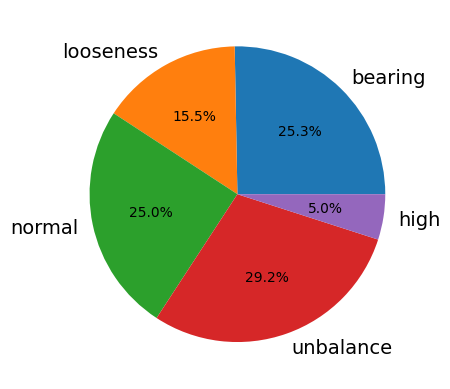

In [102]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

_, texts, _ = plt.pie([bearing, looseness, normal, unbalance, high], labels=['bearing', 'looseness', 'normal', 'unbalance', 'high'], autopct='%.1f%%')

for items in texts:
    items.set_color('black') 
    items.set_fontsize('14')

plt.show()

In [86]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __len__(self):
        assert len(self.x) == len(self.y)
        return len(self.x)
        
    def __getitem__(self, idx):
        return(self.x[idx], self.y[idx])

    def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
        
    # Normal[label 0] → Fault-free operating condition
    # Unbalance[label 1] → Unbalance between centers of mass and axis
    # Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
    # Belt-Looseness High[label 3] → High Looseness of V-belt
    # Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

        Number_of_samples = int(df.shape[0] / window) - 30
        data_array = np.zeros((Number_of_samples, time_series_length, NumofChannel)) # Defines input shape 
        for i in tqdm(range(Number_of_samples)):
            data_array[i]= df.iloc[window*i : window*i + time_series_length, : ]

        label_array = np.full_like((data_array), label)
        data_tensor = torch.from_numpy(data_array).float()
        label_tensor = torch.from_numpy(label_array).int()
        mydataset = MyDataset(data_tensor, label_tensor)
        return mydataset

    def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
        
        Number_of_samples = int(df.shape[0] / window)
        data_array = np.zeros((Number_of_samples, time_series_length, NumofChannel))
        for i in range(Number_of_samples):
            data_array[i]= df.iloc[window*i : window*i + time_series_length, : ]

        label_array = np.full_like((data_array), label)
        data_tensor = torch.from_numpy(data_array).float()
        label_tensor = torch.from_numpy(label_array).int()
        mydataset = MyDataset(data_tensor, label_tensor)
        return mydataset
        

In [88]:
sub = pd.read_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK1-Fault_Detection\Data\sub\sample_submission_classification - 복사본.csv')
final = pd.read_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK1-Fault_Detection\Data\sub\final.csv').iloc[:,1:]
Test_Dataset = TEST_Dataset_Constructor(final)

In [121]:
Test_Dataset.__len__()
#(instance, time_series_length, channel)

12592

In [145]:
a = np.full((128,),3)
a

2

## Dataset Construction/Augmentation and Solving Class Imbalance Problem

In [91]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4)
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 30)

100%|██████████| 392628/392628 [00:10<00:00, 37089.52it/s]


In [92]:
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4)
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184473/184473 [00:05<00:00, 36639.70it/s]


In [93]:
Bearing1st_ds.__len__()

148245

463447 468686 408273 541754 392628


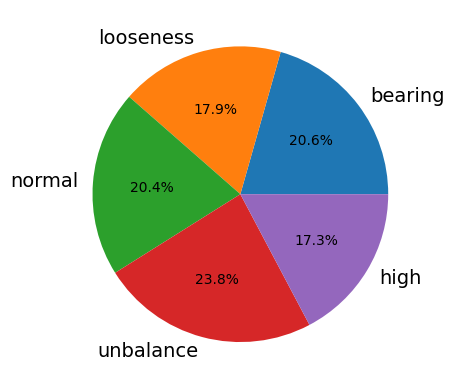

In [103]:
bearing = len(Bearing1st_ds) + len(Bearing2nd_ds)
looseness = len(Looseness1st_ds) + len(Looseness2nd_ds)
normal = len(Normal1st_ds) + len(Normal3rd_ds)
unbalance = len(Unbalance1st_ds) + len(Unbalance2nd_ds) + len(Unbalance3rd_ds)
high = len(High1st_ds)

_, texts, _ = plt.pie([bearing, looseness, normal, unbalance, high], labels=['bearing', 'looseness', 'normal', 'unbalance', 'high'], autopct='%.1f%%')
for items in texts:
    items.set_color('black') 
    items.set_fontsize('14')
print(normal, bearing, looseness, unbalance, high)

plt.show()

In [160]:
from torch.utils.data import ConcatDataset

Dataset = ConcatDataset([
    Normal1st_ds,
    Bearing1st_ds,
    Unbalance1st_ds,
    Looseness1st_ds,
    High1st_ds,
    Bearing2nd_ds,
    Unbalance2nd_ds,
    Looseness2nd_ds,
    Normal3rd_ds,
    Unbalance3rd_ds
])
Dataset.__len__()

2274788

In [161]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
val_length = int(0.2*Dataset.__len__())
train_length = int(Dataset.__len__() - val_length)

train_dataset, val_dataset = random_split(Dataset, [train_length, val_length])

train_loader = DataLoader(train_dataset, batch_size = 32)
val_loader = DataLoader(val_dataset, batch_size = 24)

In [162]:
tmp = Dataset.t

In [164]:
tmp.shape

AttributeError: 'list' object has no attribute 'shape'

In [154]:
datasets = []
for i in range(3):
    datasets.append(TensorDataset(torch.arange(i*10, (i+1)*10)))

dataset = ConcatDataset(datasets)
loader = DataLoader(
    dataset,
    shuffle=True,
    num_workers=0,
    batch_size=2
)

for data in loader:
    print(data)

[tensor([21,  6])]
[tensor([ 5, 15])]
[tensor([ 4, 13])]
[tensor([20, 12])]
[tensor([16, 26])]
[tensor([24,  0])]
[tensor([ 2, 28])]
[tensor([11, 25])]
[tensor([18, 14])]
[tensor([17,  1])]
[tensor([22, 23])]
[tensor([10, 29])]
[tensor([8, 3])]
[tensor([19,  9])]
[tensor([27,  7])]


In [158]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(train_loader):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

ValueError: x and y can be no greater than 2D, but have shapes (32,) and (32, 128, 2)

# VISUALIZATION

In [150]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(torch.flatten(Dataset):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

TypeError: '<' not supported between instances of 'tuple' and 'int'

# Fast Fourier Transform and Continuous Wavelet Transform

In [ ]:
Sample = list(Train_Dataset.unbatch().take(3000).as_numpy_iterator())[0][0]

## https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html

## https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

In [ ]:
import pywt
from scipy import fftpack
# fft : 신호 데이터셋에서 시간 정보를 없애므로 정보 손실 발생하는 단점이 존재함.
# wavelet transform : wavelet을 filter로서 사용, 

In [ ]:
coef, freqs = pywt.cwt(Sample ,np.arange(1,128), 'gaus1' , axis = 0)

fig = plt.figure()
fig.set_size_inches(8, 8)
plt.title("CWT Result of Sample Data")
plt.imshow(coef[:,:,0])

In [ ]:
imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.figure().set_size_inches(8, 8)
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

# CUSTOM MODELING

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_categorical_accuracy',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq = 'epoch'
)
earlystop = EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0.003,  # minimum value to determine 'improved'
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)

reduce = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.5, 
    patience=10,
    min_delta = 0.003,  
    verbose=1, 
    mode='auto',
    cooldown = 1 
)

callbacks = [checkpoint, earlystop, tensorboard, reduce]

In [ ]:
CUSTOM_MODEL = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(128, 2)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units = 5, activation = 'softmax')
])

CUSTOM_MODEL.summary()

CUSTOM_MODEL.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['categorical_accuracy']) # ANY CALLBACKS?



CUSTOM_MODEL.fit(Train_Dataset,
                epochs = 10, 
                validation_data = Valid_Dataset,
                callbacks = callbacks
                )

In [ ]:
pred = CUSTOM_MODEL.predict(test_Dataset)
a = np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/CUSTOM_MODEL.csv', index = False)
sub.hist()

In [ ]:
%load_ext tensorboard